# Basic Analysis

## Tweet and user volume

In [1]:
import pandas as pd
import numpy as np
import warnings
import re
import itertools
import collections
from datetime import datetime
from matplotlib import pyplot as plt
import nltk
from nltk.corpus import stopwords
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv ('data/tweets/IchBinHanna.csv')
df= df[['author.description', 'author.id', 'author.name', 'author.public_metrics.followers_count', 'author.public_metrics.following_count', 'author.username', 'author_id', 'created_at', 'id', 'lang', 'public_metrics.retweet_count','text', 'hashtags','reference_type','wanted_tag']]
user_profiles = pd.read_csv('data/tweets/TwitterUserClassification.csv')
user_merge = user_profiles[['author.id', 'user.group']]
df = df.merge(user_merge)

In [3]:
#only keep tweets from 01/06/2021 - 30/09/2021
df['new_date'] = pd.to_datetime(df['created_at']).dt.strftime('%Y-%m-%d %H:%M:%S')
df_date = df.loc[(df['new_date'] > '2021-06-01 00:00:00') & (df['new_date'] <= '2021-09-30 23:59:59')]

In [4]:
#number of total tweets
print(df.shape[0])
#number of total unique users
print(len(pd.unique(df['author.id'])))

111334
13948


In [5]:
#List the distribution of languages in the tweets (important for preprocessing (stopwords etc.))
print(df_date['lang'].value_counts())

de     95119
en     12403
und     3111
fr       246
ja        57
es        47
nl        44
is        29
it        28
da        21
pt        20
lt        18
no        14
tr        14
pl        14
ca        12
sv        10
ro         5
et         4
hi         4
tl         3
fi         3
ar         3
in         3
lv         3
cs         2
fa         2
cy         2
vi         1
zh         1
ht         1
eu         1
Name: lang, dtype: int64


As tweets with undefined language mostly consist of only hashtags, URls or emojis, they will be discarded. Otherwise only german and english tweets are kept for the analysis

In [6]:
df_date = df_date.loc[(df_date['lang'] == "de") | (df_date['lang'] == "en")]

In [7]:
pd.set_option('display.max_rows', 100)
#number of remaining tweets
print(df_date.shape[0])
#number of remaining unique users
print(len(pd.unique(df_date['author.id'])))
#overview over "missing values"
print(df_date.count())

107522
13611
author.description                       102709
author.id                                107522
author.name                              107522
author.public_metrics.followers_count    107522
author.public_metrics.following_count    107522
author.username                          107522
author_id                                107522
created_at                               107522
id                                       107522
lang                                     107522
public_metrics.retweet_count             107522
text                                     107522
hashtags                                  69374
reference_type                           107522
wanted_tag                               107522
user.group                                75129
new_date                                 107522
dtype: int64


<AxesSubplot:xlabel='week'>

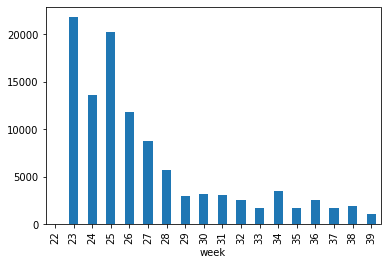

In [8]:
week_groups = df_date.groupby([pd.to_datetime(df_date['new_date']).dt.isocalendar().week]).size()
week_groups.plot(kind='bar', legend = False)

In [9]:
df_june = df_date.loc[(df_date['new_date'] > '2021-06-01 00:00:00') & (df_date['new_date'] <= '2021-06-30 23:59:59')]
df_july = df_date.loc[(df_date['new_date'] > '2021-07-01 00:00:00') & (df_date['new_date'] <= '2021-07-31 23:59:59')]
df_august = df_date.loc[(df_date['new_date'] > '2021-08-01 00:00:00') & (df_date['new_date'] <= '2021-08-31 23:59:59')]
df_september = df_date.loc[(df_date['new_date'] > '2021-09-01 00:00:00') & (df_date['new_date'] <= '2021-09-30 23:59:59')]

<AxesSubplot:xlabel='new_date'>

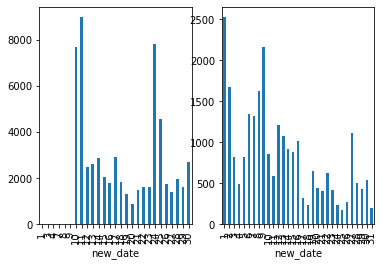

In [10]:
june_groups = df_june.groupby([pd.to_datetime(df_june['new_date']).dt.day]).size()
plt.subplot(1, 2, 1)
june_groups.plot(kind='bar', legend = False)
july_groups = df_july.groupby([pd.to_datetime(df_july['new_date']).dt.day]).size()
plt.subplot(1, 2, 2)
july_groups.plot(kind='bar', legend = False)

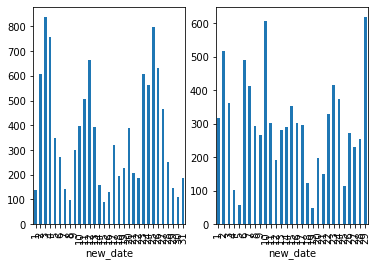

In [11]:
august_groups = df_august.groupby([pd.to_datetime(df_august['new_date']).dt.day]).size()
plt.subplot(1, 2, 1)
august_groups.plot(kind='bar', legend = False)
september_groups = df_september.groupby([pd.to_datetime(df_september['new_date']).dt.day]).size()
plt.subplot(1, 2, 2)
september_groups.plot(kind='bar', legend = False)
plt.xticks(rotation ='vertical')
plt.show()

## Missing Hashtag-Problem

In [12]:
#number of tweets actually containing the hashtag
df_hash = df_date[df_date['text'].str.contains("#ichbinhanna", case = False)]
print(df_hash.shape[0])

60680


In [13]:
#number of tweets not containing the hashtag directly
df_no_hash = df_date[-df_date['text'].str.contains("#ichbinhanna", case = False)]
print(df_no_hash.shape[0])

46842


In [14]:
#number of tweets without the hashtag that are retweets (text from original tweet cut off)
print(df_no_hash[df_no_hash['reference_type'] == 'retweeted'].shape[0])
#number of tweets with the hashtag that are retweets
print(df_hash[df_hash['reference_type'] == 'retweeted'].shape[0])

43217
40859


In [15]:
test =df_no_hash['text'].loc[df_no_hash['reference_type'] != 'retweeted']
test

1         Hanna is probably packing her/his/they suitcas...
5         Are you tired of the rigors of academic produc...
7         Thread about conference lectures, stress and e...
21        An argument typical of the capitalist and merc...
36        If we continue to discuss these issues in Germ...
                                ...                        
111299    "Was ich hier im Bildungswesen beobachte, ist ...
111300    "Was ich hier im Bildungswesen beobachte, ist ...
111307    if academia doesn’t work out, i will just over...
111317    "Ich vergleiche es mit dem Spiel Reise nach Je...
111321    @jenniferhenkeHB @mlewandowsky Mehr Geld oder ...
Name: text, Length: 3625, dtype: object

In [16]:
print(df_hash['reference_type'].value_counts())
print(df_no_hash['reference_type'].value_counts())

retweeted       40859
no_reference     8038
quoted           6221
replied_to       5562
Name: reference_type, dtype: int64
retweeted       43217
replied_to       2446
no_reference      717
quoted            462
Name: reference_type, dtype: int64


As a majority of those tweets are retweets that are mostly cut off due to the character constraint, a first approach is to exclude retweets directly for the sentiment analysis, as the original tweet (as long as it falls into our time frame) is most likely in the collection as well. If certain users or networks have to be observed, the whole data set might be of more interest.

In [17]:
#for further investigation
compression_opts = dict(method='zip',
                        archive_name='out.csv')  
df_no_hash.to_csv('out.zip', index=False,
          compression=compression_opts) 

## Get top hashtags appearing in tweets along with #IchBinHanna in september

In [18]:
#make the hashtags a list of strings, then adapt the monthly data frames, also remove tweets not containing the hashtag,
#but keep retweets for this part of the analysis
df_date = df_hash
df_date['hashtags'] = df_hash['hashtags'].str.replace('[', '').str.replace(']','')
df_date['hashtags separated'] = df_date['hashtags'].str.split(',')
df_september = df_date.loc[(df_date['new_date'] > '2021-09-01 00:00:00') & (df_date['new_date'] <= '2021-09-30 23:59:59')]
df_june = df_date.loc[(df_date['new_date'] > '2021-06-01 00:00:00') & (df_date['new_date'] <= '2021-06-30 23:59:59')]
df_july = df_date.loc[(df_date['new_date'] > '2021-07-01 00:00:00') & (df_date['new_date'] <= '2021-07-31 23:59:59')]
df_august = df_date.loc[(df_date['new_date'] > '2021-08-01 00:00:00') & (df_date['new_date'] <= '2021-08-31 23:59:59')]
june_groups = df_june.groupby([pd.to_datetime(df_june['new_date']).dt.day]).size()
july_groups = df_july.groupby([pd.to_datetime(df_july['new_date']).dt.day]).size()
august_groups = df_august.groupby([pd.to_datetime(df_august['new_date']).dt.day]).size()
september_groups = df_september.groupby([pd.to_datetime(df_september['new_date']).dt.day]).size()

In [19]:
print(len(df_september))
print(len(df_june))
print(len(df_july))
print(len(df_august))

4473
36954
13750
5503


In [20]:
#flatten the lists to count occurences of all strings and drop all variations of #IchBinHanna
flat_hashtags = df_september['hashtags separated'].explode().to_frame().dropna()
flat_hashtags = flat_hashtags[-flat_hashtags['hashtags separated'].str.contains("ichbinhanna", case = False)]

In [21]:
#count occurences 
hashtag_count = flat_hashtags.value_counts()
hashtag_count = hashtag_count[hashtag_count > 10].reset_index()

In [22]:
#for further investigation
compression_opts = dict(method='zip',
                        archive_name='top_hashtags.csv')  
hashtag_count.to_csv('out.zip', index=False,
          compression=compression_opts) 

## Identify Events by observing spikes in tweet volume

In [23]:
print("Highest activity in June:\n{}".format(june_groups.sort_values(ascending = False).head(10)))
print("Highest activity in July:\n{}".format(july_groups.sort_values(ascending = False).head(10)))
print("Highest activity in August:\n{}".format(august_groups.sort_values(ascending = False).head(10)))
print("Highest activity in September:\n{}".format(september_groups.sort_values(ascending = False).head(10)))

Highest activity in June:
new_date
11    5951
10    4486
24    4092
25    2983
14    1846
17    1666
30    1526
12    1499
13    1424
26    1261
dtype: int64
Highest activity in July:
new_date
1     1478
9     1273
2     1056
8     1052
6      712
7      700
12     677
16     509
13     486
10     478
dtype: int64
Highest activity in August:
new_date
3     496
25    445
2     396
12    370
4     349
10    277
26    271
23    269
11    209
20    208
dtype: int64
Highest activity in September:
new_date
10    399
29    367
23    285
6     246
2     245
7     230
24    201
1     198
11    193
22    175
dtype: int64


### First approach: search for most frequent words in tweets with the hashtag for the days with the highest activity

Retweets are kept here, as they give an indication about the engagement of a topic and reflect that in a higher word count for frequently discussed themes.

In [24]:
#First step: process the raw text data
#remove linebreaks separately
df_date['processed text'] = df_date['text'].replace(r'\\n',  ' ', regex=True)
#function to remove URLs, punctuation, @ etc. (source: https://www.earthdatascience.org/courses/use-data-open-source-python/intro-to-apis/calculate-tweet-word-frequencies-in-python/)
def rem_url(tweet):
     return " ".join(re.sub("([^0-9A-Za-zßäöü \t])|(\w+:\/\/\S+)", " ", tweet).split())
df_date['processed text'] = df_date['processed text'].apply(rem_url)

In [25]:
#lowercases and tokenize text
df_date['processed text'] = df_date['processed text'].str.lower().str.split()

In [26]:
#remove german and english stopwords (separately for the given language of a tweet)
nltk.download("stopwords")
german_stop = set(stopwords.words('german'))
english_stop = set(stopwords.words('english'))
df_date['processed w/o stopwords'] = df_date[['processed text','lang']].apply(lambda x: ' '.join([word for word in x['processed text'] if word not in (english_stop)]).split() if x['lang'] == 'en' else ' '.join([word for word in x['processed text'] if word not in (german_stop)]).split(),axis=1)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [27]:
#remove all words consisting of only one character (isn'"t", it'"s" etc.)
df_date['processed w/o stopwords'] = df_date['processed w/o stopwords'].apply(lambda x: [word for word in x if len(word) > 2])

In [28]:
#most frequent words overall
all_words = list(itertools.chain(*df_date['processed w/o stopwords']))
total_word_count = collections.Counter(all_words)
total_word_count.most_common(25)

[('ichbinhanna', 59081),
 ('innen', 6207),
 ('amreibahr', 5617),
 ('bund', 5322),
 ('amp', 5096),
 ('bmbf', 5052),
 ('wissenschaft', 4535),
 ('wisszeitvg', 4396),
 ('hanna', 4067),
 ('wissenschaftler', 3641),
 ('drkeichhorn', 3420),
 ('viele', 3175),
 ('mehr', 2962),
 ('german', 2832),
 ('mal', 2485),
 ('heute', 2442),
 ('ichbinhannah', 2251),
 ('system', 2232),
 ('geht', 2091),
 ('schon', 1965),
 ('anjakarliczek', 1828),
 ('gibt', 1822),
 ('gew', 1763),
 ('gerade', 1756),
 ('hannaimbundestag', 1721)]

In [29]:
#remove additional stopwords encountered (like "innen" which occurs because of gendering in german), as well as the hashtag itself, rt etc.
add_stop_all = ["rt", "ichbinhanna", "hanna", "amp"]
add_stop_ger = ["mehr", "mal", "innen", "ja", "schon"]
add_stop_en = []
df_date['processed w/o stopwords'] = df_date[['processed w/o stopwords','lang']].apply(lambda x: ' '.join([word for word in x['processed w/o stopwords'] if word not in (add_stop_all) and word not in  (add_stop_en)]).split() if x['lang'] == 'en' else ' '.join([word for word in x['processed w/o stopwords'] if word not in (add_stop_all) and word not in  (add_stop_ger)]).split(),axis=1)

In [30]:
#get most frequent terms for days with highest tweet volume per month
current_day = df_date.loc[(df_date['new_date'] > '2021-06-10 00:00:00') & (df_date['new_date'] <= '2021-06-10 23:59:59')]
daily_words = list(itertools.chain(*current_day['processed w/o stopwords']))
daily_word_count = collections.Counter(daily_words)
print("10.06.:\n{}".format(daily_word_count.most_common(25)))
current_day = df_date.loc[(df_date['new_date'] > '2021-06-11 00:00:00') & (df_date['new_date'] <= '2021-06-11 23:59:59') ]
daily_words = list(itertools.chain(*current_day['processed w/o stopwords']))
daily_word_count = collections.Counter(daily_words)
print("11.06.:\n{}".format(daily_word_count.most_common(25)))
current_day = df_date.loc[(df_date['new_date'] > '2021-06-24 00:00:00') & (df_date['new_date'] <= '2021-06-24 23:59:59') ]
daily_words = list(itertools.chain(*current_day['processed w/o stopwords']))
daily_word_count = collections.Counter(daily_words)
print("24.06.:\n{}".format(daily_word_count.most_common(25)))
current_day = df_date.loc[(df_date['new_date'] > '2021-06-25 00:00:00') & (df_date['new_date'] <= '2021-06-25 23:59:59') ]
daily_words = list(itertools.chain(*current_day['processed w/o stopwords']))
daily_word_count = collections.Counter(daily_words)
print("25.06.:\n{}".format(daily_word_count.most_common(25)))
current_day = df_date.loc[(df_date['new_date'] > '2021-06-17 00:00:00') & (df_date['new_date'] <= '2021-06-17 23:59:59') ]
daily_words = list(itertools.chain(*current_day['processed w/o stopwords']))
daily_word_count = collections.Counter(daily_words)
print("17.06.:\n{}".format(daily_word_count.most_common(25)))
current_day = df_date.loc[(df_date['new_date'] > '2021-06-30 00:00:00') & (df_date['new_date'] <= '2021-06-30 23:59:59') ]
daily_words = list(itertools.chain(*current_day['processed w/o stopwords']))
daily_word_count = collections.Counter(daily_words)
print("30.06.:\n{}".format(daily_word_count.most_common(25)))
current_day = df_date.loc[(df_date['new_date'] > '2021-07-01 00:00:00') & (df_date['new_date'] <= '2021-07-01 23:59:59') ]
daily_words = list(itertools.chain(*current_day['processed w/o stopwords']))
daily_word_count = collections.Counter(daily_words)
print("01.07.:\n{}".format(daily_word_count.most_common(25)))
current_day = df_date.loc[(df_date['new_date'] > '2021-07-02 00:00:00') & (df_date['new_date'] <= '2021-07-02 23:59:59') ]
daily_words = list(itertools.chain(*current_day['processed w/o stopwords']))
daily_word_count = collections.Counter(daily_words)
print("02.07.:\n{}".format(daily_word_count.most_common(25)))
current_day = df_date.loc[(df_date['new_date'] > '2021-07-09 00:00:00') & (df_date['new_date'] <= '2021-07-09 23:59:59') ]
daily_words = list(itertools.chain(*current_day['processed w/o stopwords']))
daily_word_count = collections.Counter(daily_words)
print("09.07.:\n{}".format(daily_word_count.most_common(25)))
current_day = df_date.loc[(df_date['new_date'] > '2021-07-08 00:00:00') & (df_date['new_date'] <= '2021-07-08 23:59:59') ]
daily_words = list(itertools.chain(*current_day['processed w/o stopwords']))
daily_word_count = collections.Counter(daily_words)
print("08.07.:\n{}".format(daily_word_count.most_common(25)))
current_day = df_date.loc[(df_date['new_date'] > '2021-08-03 00:00:00') & (df_date['new_date'] <= '2021-08-03 23:59:59') ]
daily_words = list(itertools.chain(*current_day['processed w/o stopwords']))
daily_word_count = collections.Counter(daily_words)
print("03.08.:\n{}".format(daily_word_count.most_common(25)))
current_day = df_date.loc[(df_date['new_date'] > '2021-08-04 00:00:00') & (df_date['new_date'] <= '2021-08-04 23:59:59') ]
daily_words = list(itertools.chain(*current_day['processed w/o stopwords']))
daily_word_count = collections.Counter(daily_words)
print("04.08.:\n{}".format(daily_word_count.most_common(25)))
current_day = df_date.loc[(df_date['new_date'] > '2021-08-25 00:00:00') & (df_date['new_date'] <= '2021-08-25 23:59:59') ]
daily_words = list(itertools.chain(*current_day['processed w/o stopwords']))
daily_word_count = collections.Counter(daily_words)
print("25.08.:\n{}".format(daily_word_count.most_common(25)))
current_day = df_date.loc[(df_date['new_date'] > '2021-08-12 00:00:00') & (df_date['new_date'] <= '2021-08-12 23:59:59') ]
daily_words = list(itertools.chain(*current_day['processed w/o stopwords']))
daily_word_count = collections.Counter(daily_words)
print("12.08.:\n{}".format(daily_word_count.most_common(25)))
current_day = df_date.loc[(df_date['new_date'] > '2021-08-26 00:00:00') & (df_date['new_date'] <= '2021-08-26 23:59:59') ]
daily_words = list(itertools.chain(*current_day['processed w/o stopwords']))
daily_word_count = collections.Counter(daily_words)
print("26.08.:\n{}".format(daily_word_count.most_common(25)))
current_day = df_date.loc[(df_date['new_date'] > '2021-09-29 00:00:00') & (df_date['new_date'] <= '2021-09-29 23:59:59') ]
daily_words = list(itertools.chain(*current_day['processed w/o stopwords']))
daily_word_count = collections.Counter(daily_words)
print("29.09.:\n{}".format(daily_word_count.most_common(25)))
current_day = df_date.loc[(df_date['new_date'] > '2021-09-10 00:00:00') & (df_date['new_date'] <= '2021-09-10 23:59:59') ]
daily_words = list(itertools.chain(*current_day['processed w/o stopwords']))
daily_word_count = collections.Counter(daily_words)
print("10.09.:\n{}".format(daily_word_count.most_common(25)))
current_day = df_date.loc[(df_date['new_date'] > '2021-09-02 00:00:00') & (df_date['new_date'] <= '2021-09-02 23:59:59') ]
daily_words = list(itertools.chain(*current_day['processed w/o stopwords']))
daily_word_count = collections.Counter(daily_words)
print("02.09.:\n{}".format(daily_word_count.most_common(25)))
current_day = df_date.loc[(df_date['new_date'] > '2021-09-06 00:00:00') & (df_date['new_date'] <= '2021-09-06 23:59:59') ]
daily_words = list(itertools.chain(*current_day['processed w/o stopwords']))
daily_word_count = collections.Counter(daily_words)
print("06.09.:\n{}".format(daily_word_count.most_common(25)))
current_day = df_date.loc[(df_date['new_date'] > '2021-09-03 00:00:00') & (df_date['new_date'] <= '2021-09-03 23:59:59') ]
daily_words = list(itertools.chain(*current_day['processed w/o stopwords']))
daily_word_count = collections.Counter(daily_words)
print("03.09.:\n{}".format(daily_word_count.most_common(25)))

10.06.:
[('wissenschaftler', 935), ('teilen', 781), ('wisszeitvg', 622), ('prekären', 592), ('befristet', 591), ('nachwuchs', 569), ('momentan', 532), ('status', 532), ('angestellte', 531), ('degneranja', 530), ('wissenschaft', 513), ('bmbf', 474), ('german', 340), ('viele', 314), ('innovation', 300), ('gerade', 266), ('deutschland', 259), ('sagt', 248), ('tatsächlich', 248), ('trending', 245), ('kontext', 244), ('sorgt', 242), ('schwere', 241), ('sahiralsaid', 239), ('fördere', 239)]
11.06.:
[('wissenschaftler', 794), ('german', 737), ('wissenschaft', 645), ('system', 598), ('viele', 591), ('teilen', 588), ('trending', 575), ('academic', 544), ('gerade', 427), ('bmbf', 374), ('academia', 334), ('since', 321), ('wisszeitvg', 315), ('know', 315), ('befristungen', 309), ('martin', 300), ('everyone', 296), ('pia', 296), ('tweets', 295), ('lamberty', 295), ('befristet', 294), ('übrigens', 293), ('messed', 293), ('hebart', 292), ('prekären', 291)]
24.06.:
[('hannaimbundestag', 1075), ('geht

### Observations June:
10th + 11th: Start of the movement under the hashtag #IchBinHanna
24th: Issue got discussed in the "aktuelle Stunde" of the german Bundestag
25th: Series of tweets of Achim Landwehr, a Dean of studies critizing and portraying the situation of scientific workers
17th: State scecretary Wolf-Dieter Lukas uploads a video addressing the issues that arose with the hashtag
14th: Initial video of the BMBF gets deleted from their website.

### Observations July:
1st +  2nd: Zoom conference of the GEW (union for education and science) 
9th: Journalist Thilo Jung presents the issue at a press conference of the german government 

### Observations August:
3rd + 4th: TV report about #IchBinHanna in ZDF's "heute journal" 

### Observations September:
2nd + 3rd: declaration of new "Berliner Hochschulgesetz"
29th: IchBinHanna discussed in the "hessischer Landtag"

## Distribution of user profiles

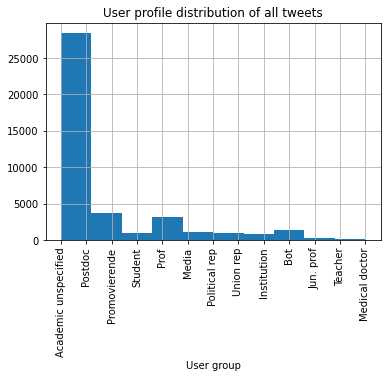

In [31]:
#whole data set
df_date['user.group'].hist()
plt.title('User profile distribution of all tweets')
plt.xlabel('User group')
plt.xticks(rotation='vertical')
plt.show()

To get a broader picture and see if the participants of the discussion changed over time, the distribution is also shown for the single months

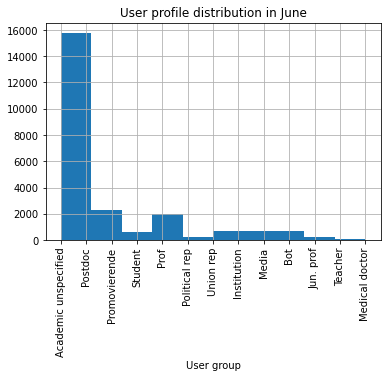

In [32]:
#distribution in June
df_june['user.group'].hist()
plt.title('User profile distribution in June')
plt.xlabel('User group')
plt.xticks(rotation='vertical')
plt.show()

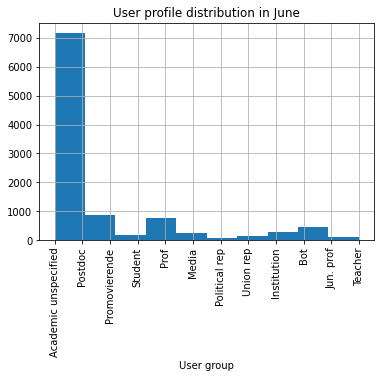

In [33]:
#distribution in June
df_july['user.group'].hist()
plt.title('User profile distribution in June')
plt.xlabel('User group')
plt.xticks(rotation='vertical')
plt.show()

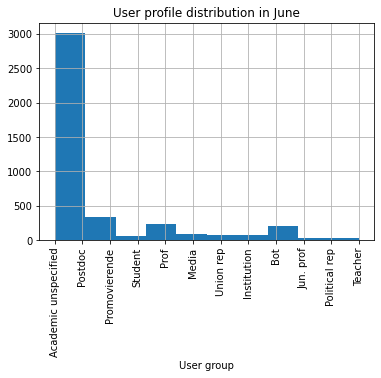

In [34]:
#distribution in June
df_august['user.group'].hist()
plt.title('User profile distribution in June')
plt.xlabel('User group')
plt.xticks(rotation='vertical')
plt.show()

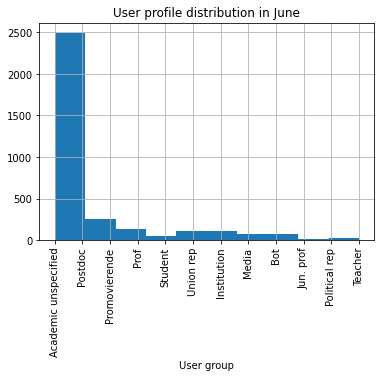

In [35]:
#distribution in June
df_september['user.group'].hist()
plt.title('User profile distribution in June')
plt.xlabel('User group')
plt.xticks(rotation='vertical')
plt.show()